In [1]:
from collections import Counter
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.integrate import quad
from scipy.stats import lognorm
from typing import Dict, List, Tuple

In [2]:
# NOTE: The report is found towards the end of this notebook, under the section titled "Report"

### Helper Code

In [3]:
# Class that holds the various parameters used in the simulations
class Parameters:
    def __init__(self, masks: bool = False, e_mu: float = 1.0, e_sigma: float = 1.0, 
                 i_mu: float = 2.25, i_sigma: float = 0.105, p_1c: float = 0.12, 
                 beta: float = -0.00504) -> None:
        self.masks = masks
        self.e_mu = e_mu
        self.e_sigma = e_sigma
        self.i_mu = i_mu
        self.i_sigma = i_sigma
        self.p_1c = p_1c
        self.beta = beta

In [4]:
# Generic state class
class State:
    def __init__(self, parameters: Parameters, color: str) -> None:
        self.parameters = parameters
        self.color = color

    def transition(self):
        pass


# Recovered state class
class Recovered(State):
    def __init__(self, parameters: Parameters, color: str = 'green') -> None:
        super().__init__(parameters, color)

    def transition(self) -> State:
        return self
    

# Recovered state class
class Infectious(State):
    def __init__(self, parameters: Parameters, color: str = 'red') -> None:
        super().__init__(parameters, color)
        mu, sigma = self.parameters.i_mu, self.parameters.i_sigma
        self.n_days_to_recovered = int(np.ceil(np.random.lognormal(mu, sigma, 1)[0]))
        self.n_days_infectious = 0

    def prob_infection(self) -> float:
        p_1c = self.parameters.p_1c * 0.35 if self.parameters.masks else self.parameters.p_1c
        beta = self.parameters.beta
        numerator = (p_1c / (1 - p_1c)) * np.exp(beta * (self.n_days_infectious ** 3 - 1))
        denominator = 1 + numerator
        prob_infection = numerator / denominator

        return prob_infection

    def transition(self) -> State:
        if self.n_days_infectious >= self.n_days_to_recovered:
            return Recovered(self.parameters)
        
        self.n_days_infectious += 1

        return self
    

# Exposed state class
class Exposed(State):
    def __init__(self, parameters: Parameters, color: str = 'yellow') -> None:
        super().__init__(parameters, color)
        mu, sigma = self.parameters.e_mu, self.parameters.e_sigma
        self.n_days_to_infectious = int(np.ceil(np.random.lognormal(mu, sigma, 1)[0]))
        self.n_days_exposed = 0

    def transition(self) -> State:
        if self.n_days_exposed >= self.n_days_to_infectious:
            return Infectious(self.parameters)

        self.n_days_exposed += 1
        
        return self


# Susceptible state class
class Susceptible(State):
    def __init__(self, parameters: Parameters, neighbors: List, color: str = 'blue') -> None:
        super().__init__(parameters, color)
        self.neighbors = neighbors

    def transition(self) -> State:
        for neighbor in self.neighbors:
            if isinstance(neighbor.curr_state, Infectious):
                prob_infected = neighbor.curr_state.prob_infection()
                random_sample = np.random.uniform()
                
                if random_sample < prob_infected:
                    return Exposed(self.parameters)
                
        return self

In [5]:
# Agent class (used to represent each node in a graph)
class Agent:
    def __init__(self, initial_state_type: type, parameters: Parameters) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.parameters = parameters
        self.neighbors = []
        self.curr_state = None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.curr_state = self.curr_state.transition()

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_initial_state(self) -> None:
        self.curr_state = self._initialize_state()

    def _initialize_state(self) -> State:
        if self.initial_state_type == Susceptible:
            return Susceptible(self.parameters, neighbors=self.neighbors)
        
        else:
            return self.initial_state_type(self.parameters)

In [6]:
# Population class (used to create and handle agents for a graph)
class Population:
    def __init__(self, graph: nx.Graph, percent_susceptible: float = 0.9, percent_exposed: float = 0.05, 
                 percent_infectious: float = 0.05, parameters: Parameters = Parameters()) -> None:
        assert percent_susceptible + percent_exposed + percent_infectious == 1.0
        self.graph = graph
        self.percent_susceptible = percent_susceptible
        self.percent_exposed = percent_exposed
        self.percent_infectious = percent_infectious
        self.parameters = parameters
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents = {}
        n_nodes = self.graph.number_of_nodes()
        node_numbers = list(range(n_nodes))
        np.random.shuffle(node_numbers)
        n_susceptible = int(n_nodes * self.percent_susceptible)
        n_exposed = int(n_nodes * self.percent_exposed)
        susceptible_indices = set(node_numbers[:n_susceptible])
        exposed_indices = set(node_numbers[n_susceptible:n_susceptible + n_exposed])
        infectious_indices = set(node_numbers[n_susceptible + n_exposed:])
        curr_index = 0

        assert len(susceptible_indices) == n_susceptible
        assert len(exposed_indices) == n_exposed
        assert len(infectious_indices) == n_nodes - (n_susceptible + n_exposed)

        for node in self.graph.nodes:
            if curr_index in susceptible_indices:
                initial_state_type = Susceptible

            elif curr_index in exposed_indices:
                initial_state_type = Exposed

            else:
                initial_state_type = Infectious

            agents[node] = Agent(initial_state_type, self.parameters)
            curr_index += 1

        for node in self.graph.nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_initial_state()

        return agents
    
    def transition(self) -> None:
        for agent in self.agents.values():
            agent.transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type
    
    def nodes_with_type(self, state_type: type) -> List[Tuple[object, str]]:
        nodes_with_type = [(node_label, agent.curr_state.color) for node_label, agent 
                           in self.agents.items() if isinstance(agent.curr_state, state_type)]
        
        return nodes_with_type
    
    def reset(self) -> None:
        self.agents = self._initialize_agents()

In [7]:
# Simulation class (used to run simulations on a population and track results)
class Simulation:
    def __init__(self, name: str, population: Population, n_iterations: int = 200, n_trials: int = 100) -> None:
        self.name = name
        self.population = population
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.susceptible_counts, self.exposed_counts, self.infectious_counts, self.recovered_counts = [], [], [], []

    def run(self, animate: bool = False) -> None:
        node_colors = []

        for _ in range(self.n_trials):
            s_counts, e_counts, i_counts, r_counts = [], [], [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(Susceptible, s_counts), 
                                                (Exposed, e_counts), 
                                                (Infectious, i_counts), 
                                                (Recovered, r_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                if animate and len(node_colors) < self.n_iterations:
                    colors = []

                    for state_type in [Susceptible, Exposed, Infectious, Recovered]:
                        nodes_with_type = self.population.nodes_with_type(state_type)
                        colors.extend(nodes_with_type)

                    node_colors.append(colors)

                self.population.transition()

            self.susceptible_counts.append(s_counts)
            self.exposed_counts.append(e_counts)
            self.infectious_counts.append(i_counts)
            self.recovered_counts.append(r_counts)

            self.population.reset()

        if animate:
            print('Done with simulations; animating...')
            graph = self.population.graph
            fig = plt.figure()
            node_positions = nx.circular_layout(graph)

            def update(frame: int) -> None:
                color_mapping = {}
                colors = node_colors[frame]

                for node, color in colors:
                    color_mapping[node] = color

                nx.draw(graph, node_positions, with_labels=True, node_color=[color_mapping[node] for node in graph.nodes])

            ani = FuncAnimation(fig, update, frames=self.n_iterations, repeat=False)
            ani.save(f'./project_1_animations/animation_{self.name}.gif', writer='imagemagick', fps=0.5)

    def plot(self) -> None:
        assert len(self.susceptible_counts) == len(self.exposed_counts) == len(self.infectious_counts) == len(self.recovered_counts) == self.n_trials
        assert len(self.susceptible_counts[0]) == len(self.exposed_counts[0]) == len(self.infectious_counts[0]) == len(self.recovered_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)

        s_mean = np.mean(self.susceptible_counts, axis=0)
        s_25 = np.percentile(self.susceptible_counts, 25, axis=0)
        s_75 = np.percentile(self.susceptible_counts, 75, axis=0)
        plt.plot(x_vals, s_mean, label='S', color='blue')
        plt.fill_between(x_vals, s_25, s_75, color='blue', alpha=0.5)

        e_mean = np.mean(self.exposed_counts, axis=0)
        e_25 = np.percentile(self.exposed_counts, 25, axis=0)
        e_75 = np.percentile(self.exposed_counts, 75, axis=0)
        plt.plot(x_vals, e_mean, label='E', color='yellow')
        plt.fill_between(x_vals, e_25, e_75, color='yellow', alpha=0.5)

        i_mean = np.mean(self.infectious_counts, axis=0)
        i_25 = np.percentile(self.infectious_counts, 25, axis=0)
        i_75 = np.percentile(self.infectious_counts, 75, axis=0)
        plt.plot(x_vals, i_mean, label='I', color='red')
        plt.fill_between(x_vals, i_25, i_75, color='red', alpha=0.5)

        r_mean = np.mean(self.recovered_counts, axis=0)
        r_25 = np.percentile(self.recovered_counts, 25, axis=0)
        r_75 = np.percentile(self.recovered_counts, 75, axis=0)
        plt.plot(x_vals, r_mean, label='R', color='green')
        plt.fill_between(x_vals, r_25, r_75, color='green', alpha=0.5)

        plt.legend(loc='best')
        plt.xlabel('Number of Days')
        plt.ylabel('Number of People')
        plt.title('Number of People in the S, E, I, or R States, Over Time')
        plt.show()

    def summary_statistics(self) -> None:
        i_mean = np.mean(self.infectious_counts, axis=0)
        e_mean = np.mean(self.exposed_counts, axis=0)
        s_mean = np.mean(self.susceptible_counts, axis=0)

        max_infections, time_to_max_infections = np.max(i_mean), np.argmax(i_mean)
        time_to_no_new_infections = np.where((i_mean <= 0.01) & (e_mean <= 0.01))[0][0]
        n_uninfected = s_mean[-1]

        print(f'Number of peak infections (on average): {max_infections}')
        print(f'Time to peak infection (on average): {time_to_max_infections}')
        print(f'Time until no new infections (on average): {time_to_no_new_infections}')
        print(f'Number of uninfected individuals at the end of the simulation (on average): {n_uninfected}')

    def graph_metrics(self) -> None:
        graph = self.population.graph

        degrees = dict(graph.degree()).values()
        degree_counts = Counter(degrees)

        plt.bar(degree_counts.keys(), degree_counts.values())
        plt.xlabel('Degree')
        plt.ylabel('Count')
        plt.title('Degree Distribution')
        plt.show()

        max_degree, avg_degree = max(degrees), sum(degrees) / len(degrees)
        diameter, radius, density = nx.diameter(graph), nx.radius(graph), nx.density(graph)

        print(f'Maximum degree: {max_degree}')
        print(f'Average degree: {avg_degree}')
        print(f'Diameter: {diameter}')
        print(f'Radius: {radius}')
        print(f'Density: {density}')

    # Used to make sure the scale-free networks follow the "straigh line" test
    def log_log_density_plot(self) -> None:
        graph = self.population.graph

        degrees = dict(graph.degree()).values()
        degree_counts = Counter(degrees)
    
        degree_values_scaled, degree_counts_scaled = np.log(list(degree_counts.keys())), np.log(list(degree_counts.values()))

        plt.scatter(degree_values_scaled, degree_counts_scaled, marker='o')
        plt.title('Degree Distribution on a Log-Log Scale')
        plt.xlabel('Log(Degree)')
        plt.ylabel('Log(Count)')
        plt.show()


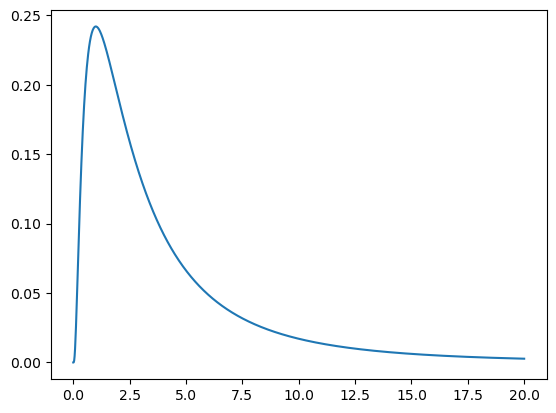

In [8]:
# Default exposure duration distribution
x = np.linspace(0, 20, 1000)
mu, sigma = 1.0, 1.0
pdf_values = lognorm.pdf(x, sigma, scale=np.exp(mu))

plt.plot(x, pdf_values)
plt.show()

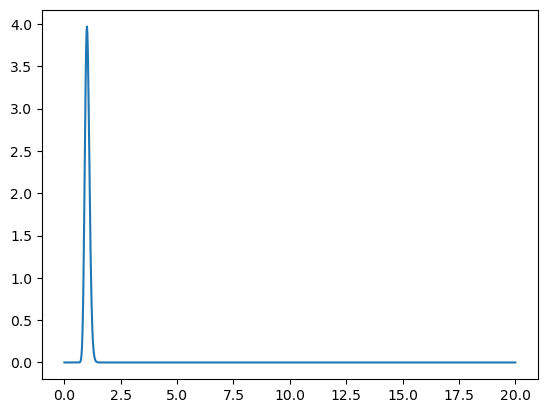

In [9]:
# Test exposure duration distribution
x = np.linspace(0, 20, 1000)
e_mu_test, e_sigma_test = 0.01, 0.1
pdf_values = lognorm.pdf(x, e_sigma_test, scale=np.exp(e_mu_test))

plt.plot(x, pdf_values)
plt.show()

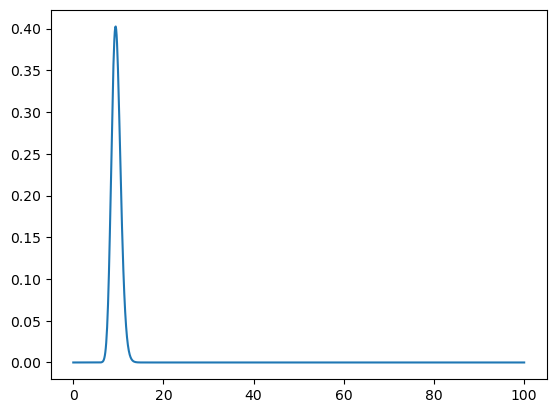

In [10]:
# Default infectious duration distribution
x = np.linspace(0, 100, 1000)
mu, sigma = 2.25, 0.105
pdf_values = lognorm.pdf(x, sigma, scale=np.exp(mu))

plt.plot(x, pdf_values)
plt.show()

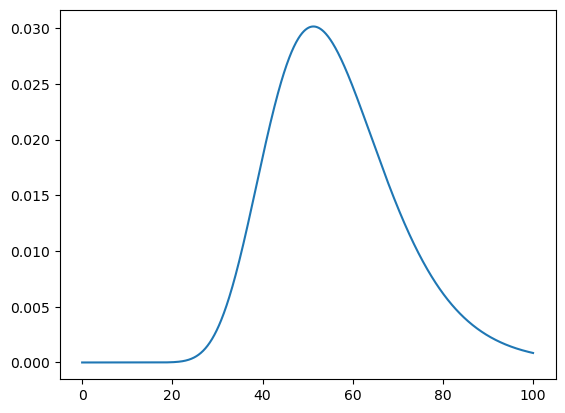

In [11]:
# Test infectious duration distribution
x = np.linspace(0, 100, 1000)
i_mu_test, i_sigma_test = 4, 0.25
pdf_values = lognorm.pdf(x, i_sigma_test, scale=np.exp(i_mu_test))

plt.plot(x, pdf_values)
plt.show()

In [12]:
def plot_infection_pdf(p_1c, beta, min_days=0, max_days=20):
    def _calculate_prob_infection(d):
        numerator = (p_1c / (1 - p_1c)) * np.exp(beta * (d ** 3 - 1))
        denominator = 1 + numerator
        
        return numerator / denominator
    
    def _pdf_to_integrate(d):
        return _calculate_prob_infection(d)

    n_days_values = np.linspace(min_days, max_days, 100)
    pdf_values = [_calculate_prob_infection(n_days) for n_days in n_days_values]

    # Normalize
    area, _ = quad(_pdf_to_integrate, min_days, max_days)
    pdf_values = np.array(pdf_values) / area

    plt.plot(n_days_values, pdf_values)
    plt.xlabel('Day')
    plt.ylabel('Probability')
    plt.title('Infection Probability')
    plt.show()

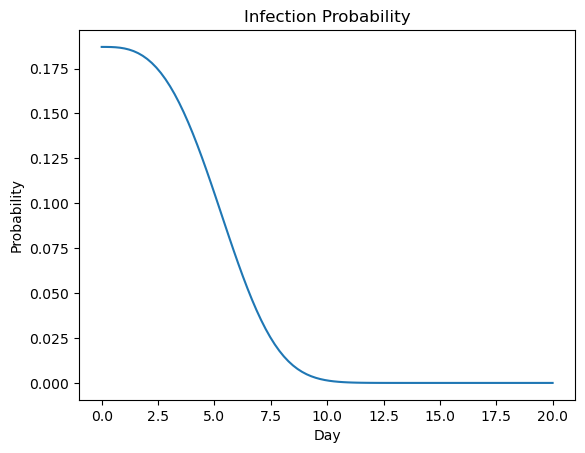

In [13]:
# Default infectious parameters
p_1c, beta = 0.12, -0.00504

plot_infection_pdf(p_1c, beta)

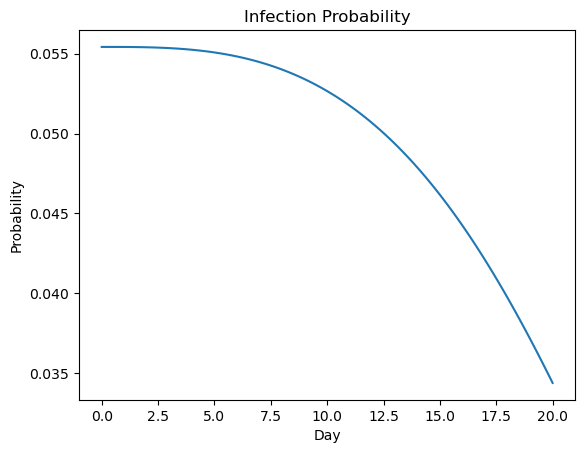

In [14]:
# Test infectious parameters
p_1c_test, beta_test = 0.5, -0.0001

plot_infection_pdf(p_1c_test, beta_test)

In [22]:
test_parameters = Parameters(False, e_mu_test, e_sigma_test, i_mu_test, i_sigma_test, p_1c_test, beta_test)

### Circulant 2

Default Parameters

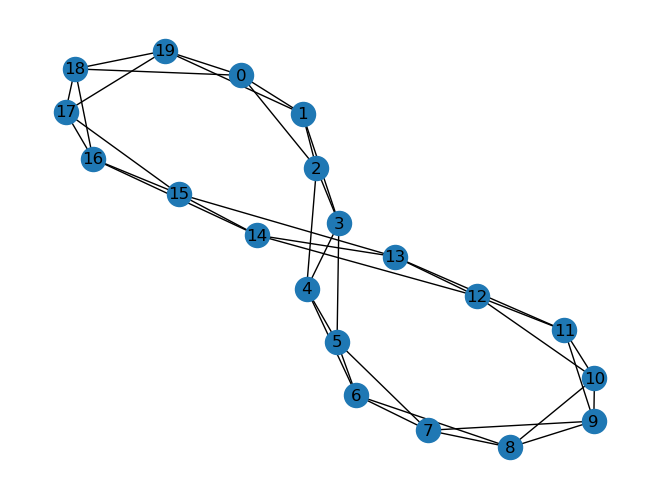

In [7]:
G = nx.circulant_graph(20, [1, 2])

nx.draw(G, with_labels=True)
plt.show()

In [8]:
population = Population(G)

In [9]:
circulant_2_sim = Simulation('circulant_2', population)

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


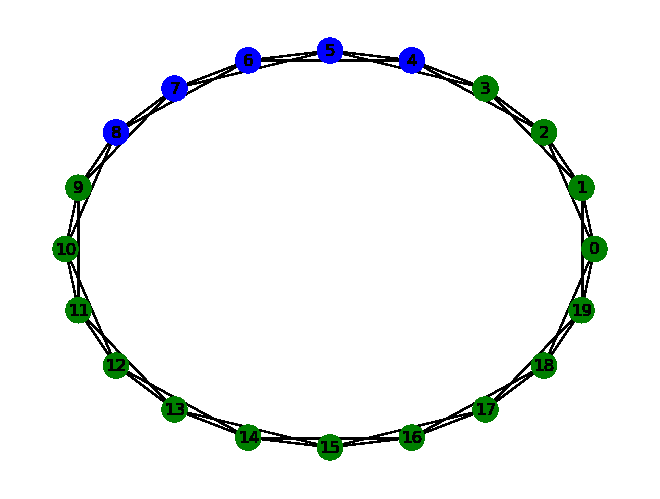

In [10]:
circulant_2_sim.run(animate=True)

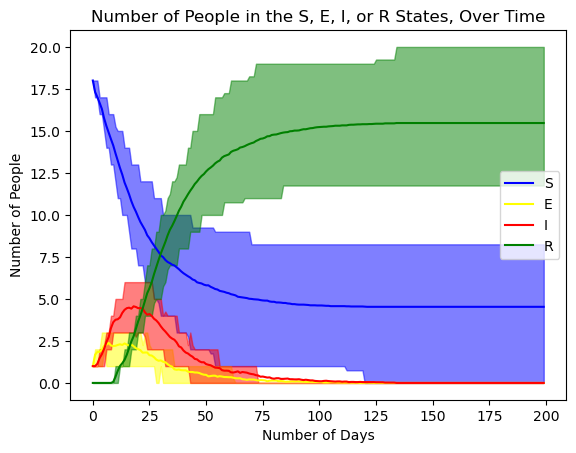

In [11]:
circulant_2_sim.plot()

In [12]:
circulant_2_sim.summary_statistics()

Number of peak infections (on average): 4.56
Time to peak infection (on average): 18
Time until no new infections (on average): 134
Number of uninfected individuals at the end of the simulation (on average): 4.53


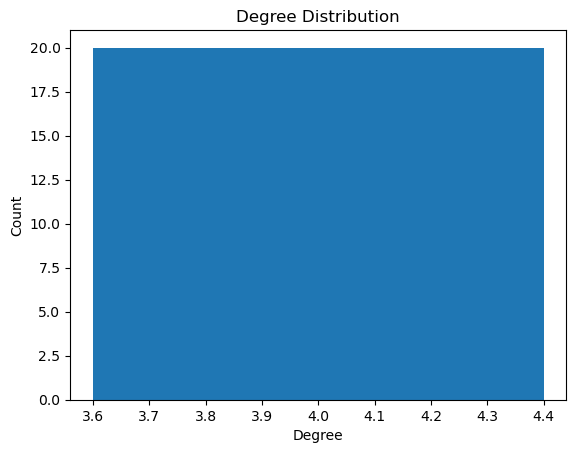

Maximum degree: 4
Average degree: 4.0
Diameter: 5
Radius: 5
Density: 0.21052631578947367


In [13]:
circulant_2_sim.graph_metrics()

### Circulant 4

 Default Parameters

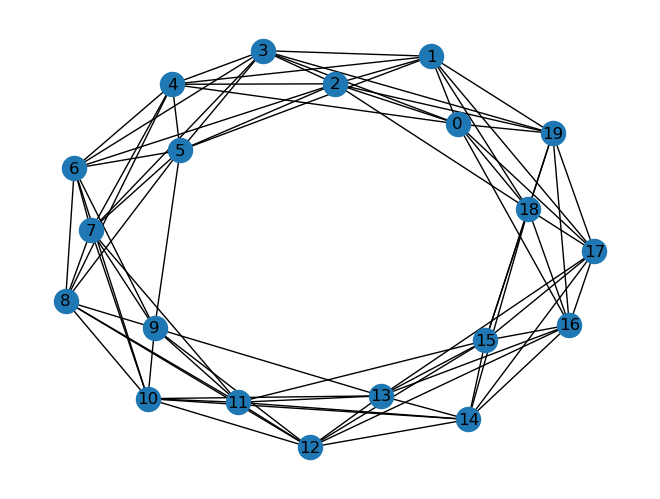

In [14]:
G = nx.circulant_graph(20, [1, 2, 3, 4])

nx.draw(G, with_labels=True)
plt.show()

In [15]:
population = Population(G)

In [16]:
circulant_4_sim = Simulation('circulant_4', population)

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


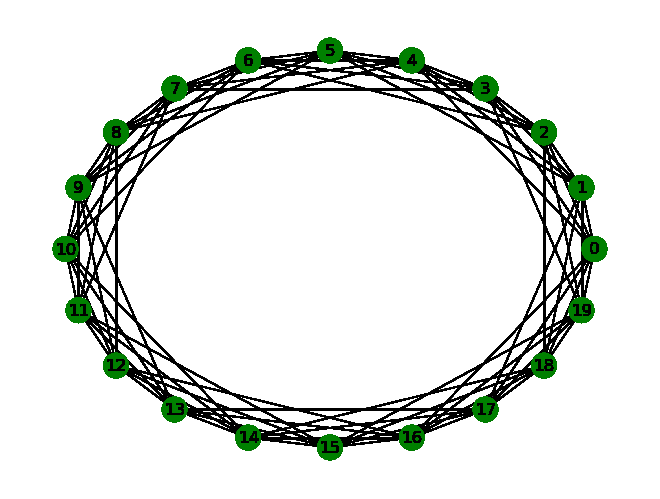

In [17]:
circulant_4_sim.run(animate=True)

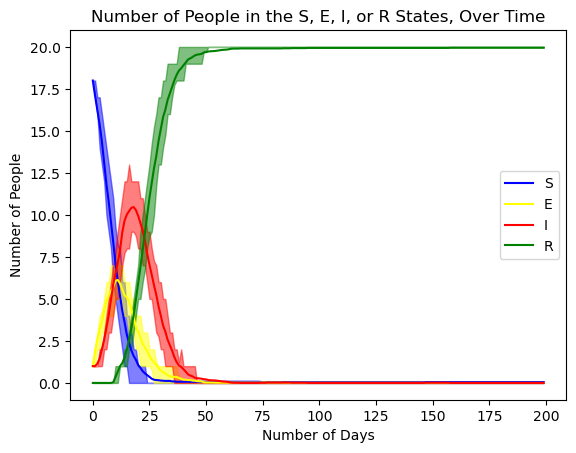

In [18]:
circulant_4_sim.plot()

In [19]:
circulant_4_sim.summary_statistics()

Number of peak infections (on average): 10.47
Time to peak infection (on average): 18
Time until no new infections (on average): 158
Number of uninfected individuals at the end of the simulation (on average): 0.05


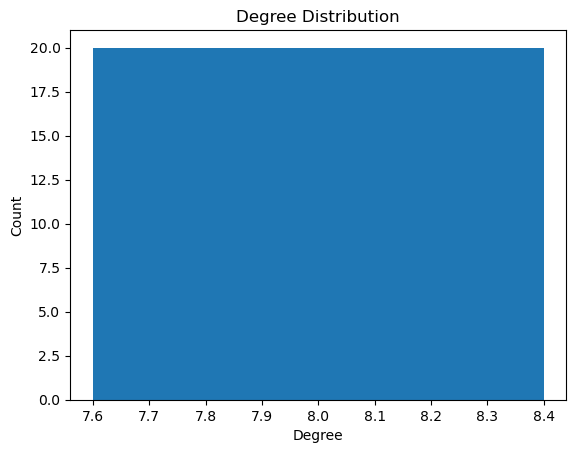

Maximum degree: 8
Average degree: 8.0
Diameter: 3
Radius: 3
Density: 0.42105263157894735


In [20]:
circulant_4_sim.graph_metrics()

### Complete

Default Parameters

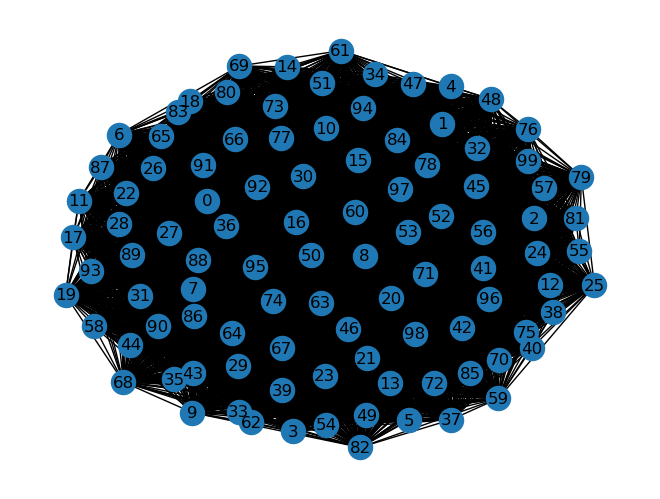

In [15]:
G = nx.complete_graph(100)

nx.draw(G, with_labels=True)
plt.show()

In [16]:
population = Population(G)

In [17]:
complete_sim = Simulation('complete', population)

In [18]:
complete_sim.run()

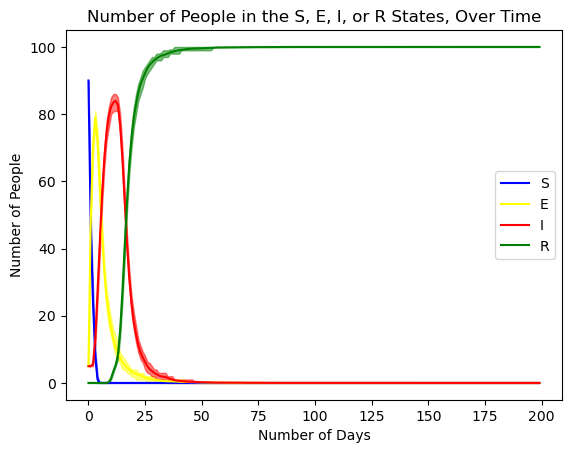

In [19]:
complete_sim.plot()

In [20]:
complete_sim.summary_statistics()

Number of peak infections (on average): 83.96
Time to peak infection (on average): 12
Time until no new infections (on average): 86
Number of uninfected individuals at the end of the simulation (on average): 0.0


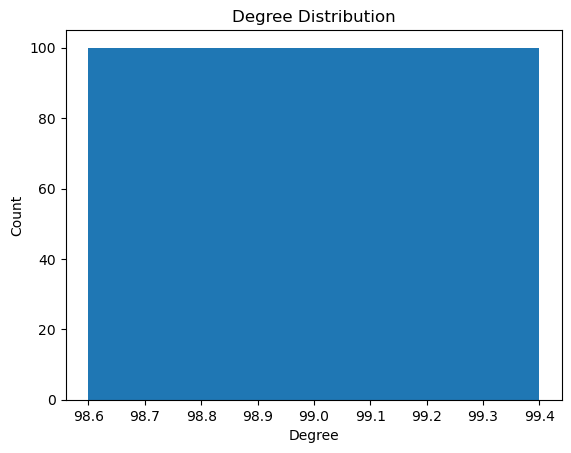

Maximum degree: 99
Average degree: 99.0
Diameter: 1
Radius: 1
Density: 1.0


In [21]:
complete_sim.graph_metrics()

Test Parameters

In [23]:
population = Population(G, parameters=test_parameters)

In [24]:
complete_sim_test = Simulation('complete_test', population)

In [25]:
complete_sim_test.run()

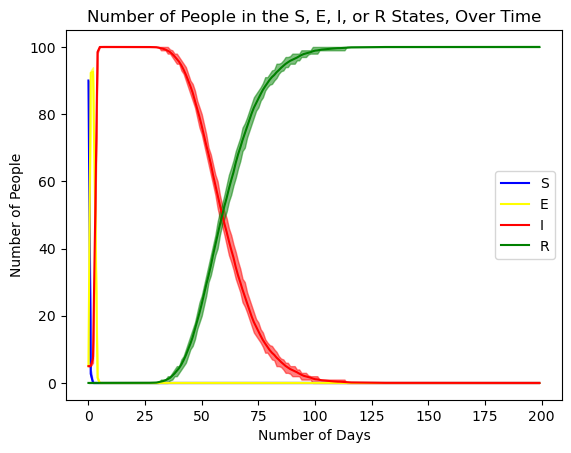

In [26]:
complete_sim_test.plot()

In [27]:
complete_sim_test.summary_statistics()

Number of peak infections (on average): 100.0
Time to peak infection (on average): 6
Time until no new infections (on average): 136
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Lattice

Default Parameters

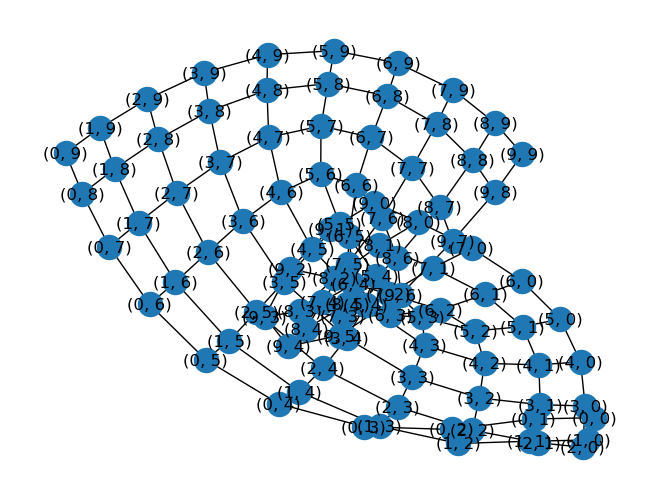

In [29]:
G = nx.grid_2d_graph(10, 10)

nx.draw(G, with_labels=True)
plt.show()

In [30]:
population = Population(G)

In [31]:
lattice_sim = Simulation('lattice', population)

In [32]:
lattice_sim.run()

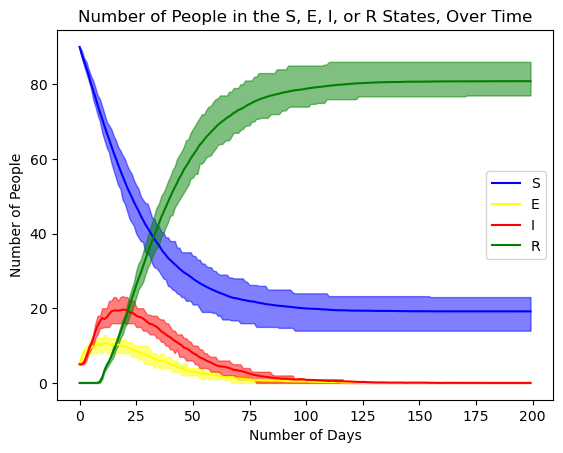

In [33]:
lattice_sim.plot()

In [34]:
lattice_sim.summary_statistics()

Number of peak infections (on average): 19.64
Time to peak infection (on average): 19
Time until no new infections (on average): 178
Number of uninfected individuals at the end of the simulation (on average): 19.17


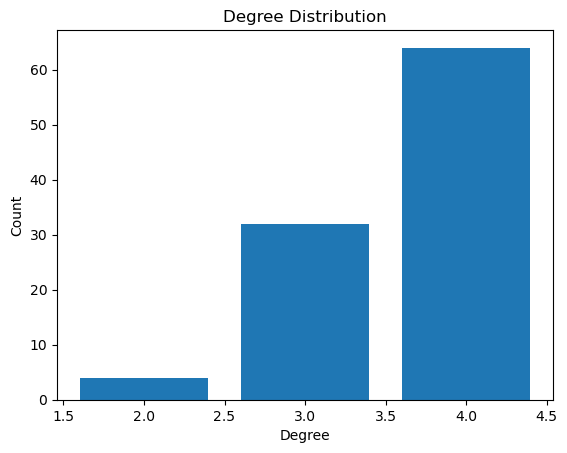

Maximum degree: 4
Average degree: 3.6
Diameter: 18
Radius: 10
Density: 0.03636363636363636


In [35]:
lattice_sim.graph_metrics()

Test Parameters

In [36]:
population = Population(G, parameters=test_parameters)

In [37]:
lattice_sim_test = Simulation('lattice_test', population)

In [38]:
lattice_sim_test.run()

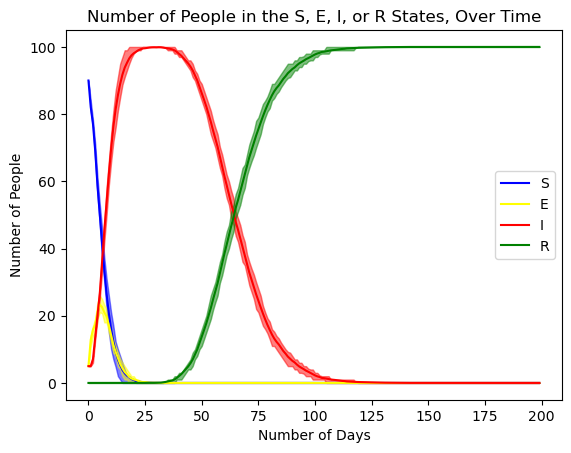

In [39]:
lattice_sim_test.plot()

In [40]:
lattice_sim_test.summary_statistics()

Number of peak infections (on average): 99.92
Time to peak infection (on average): 31
Time until no new infections (on average): 140
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Scale-Free 100

Default Parameters

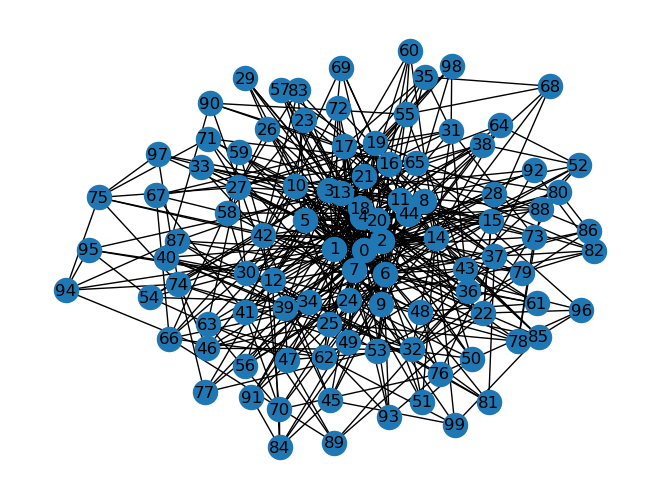

In [41]:
G = nx.barabasi_albert_graph(100, 5, initial_graph=nx.complete_graph(5))

nx.draw(G, with_labels=True)
plt.show()

In [42]:
population = Population(G)

In [43]:
scale_free_100_sim = Simulation('scale_free_100', population)

In [44]:
scale_free_100_sim.run()

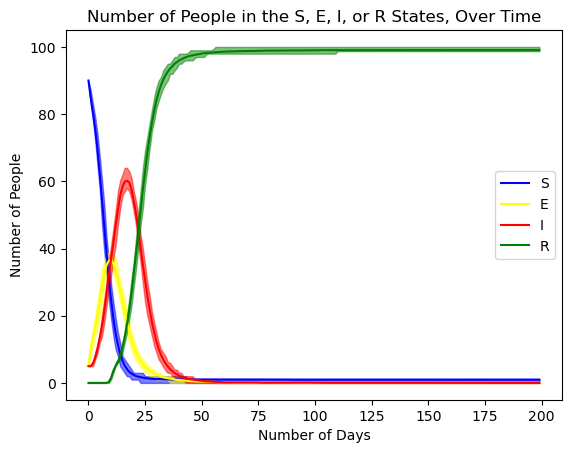

In [45]:
scale_free_100_sim.plot()

In [46]:
scale_free_100_sim.summary_statistics()

Number of peak infections (on average): 60.13
Time to peak infection (on average): 17
Time until no new infections (on average): 109
Number of uninfected individuals at the end of the simulation (on average): 0.95


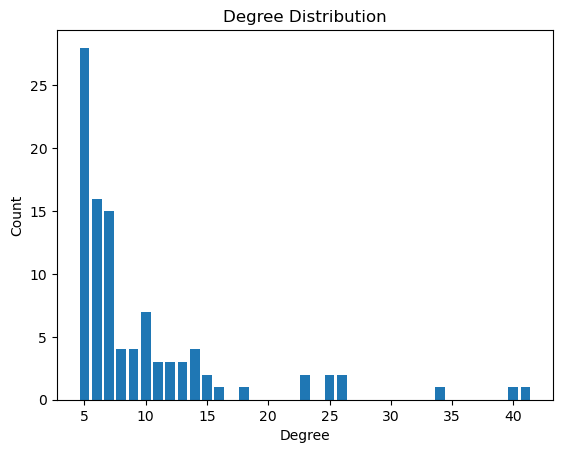

Maximum degree: 41
Average degree: 9.7
Diameter: 4
Radius: 2
Density: 0.09797979797979799


In [47]:
scale_free_100_sim.graph_metrics()

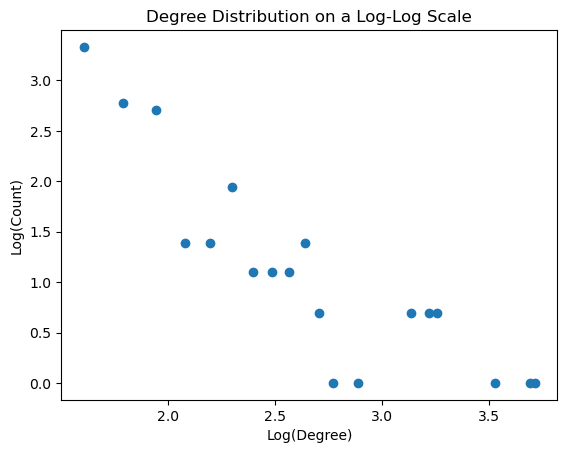

In [48]:
scale_free_100_sim.log_log_density_plot()

Test Parameters

In [49]:
population = Population(G, parameters=test_parameters)

In [50]:
scale_free_100_sim_test = Simulation('scale_free_100_test', population)

In [51]:
scale_free_100_sim_test.run()

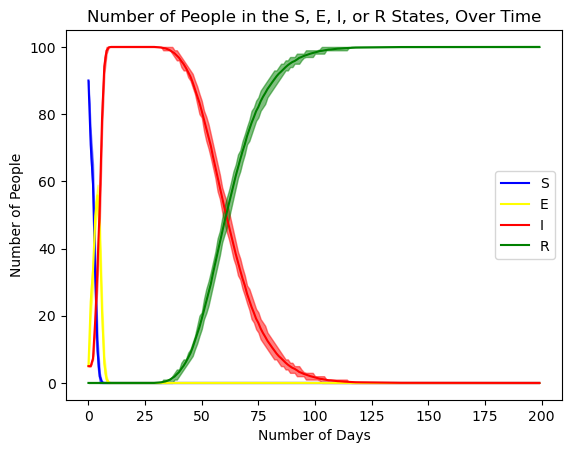

In [52]:
scale_free_100_sim_test.plot()

In [53]:
scale_free_100_sim_test.summary_statistics()

Number of peak infections (on average): 100.0
Time to peak infection (on average): 10
Time until no new infections (on average): 153
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Scale-Free 410

Default Parameters

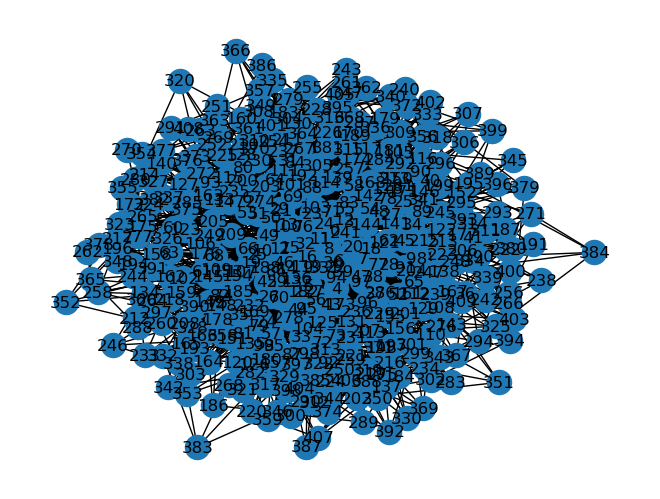

In [54]:
G = nx.barabasi_albert_graph(410, 5, initial_graph=nx.complete_graph(5))

nx.draw(G, with_labels=True)
plt.show()

In [55]:
population = Population(G)

In [56]:
scale_free_410_sim = Simulation('scale_free_410', population)

In [57]:
scale_free_410_sim.run()

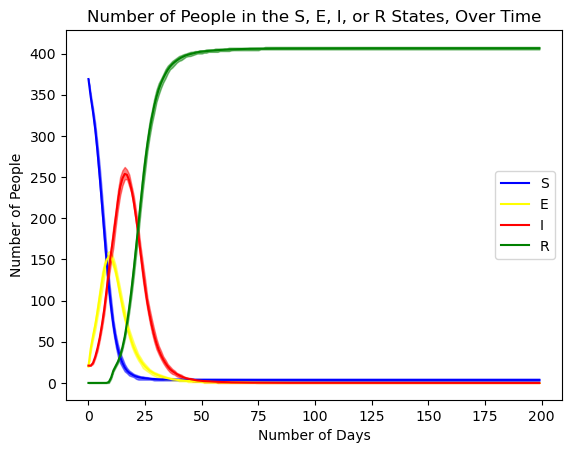

In [58]:
scale_free_410_sim.plot()

In [59]:
scale_free_410_sim.summary_statistics()

Number of peak infections (on average): 253.81
Time to peak infection (on average): 16
Time until no new infections (on average): 144
Number of uninfected individuals at the end of the simulation (on average): 3.64


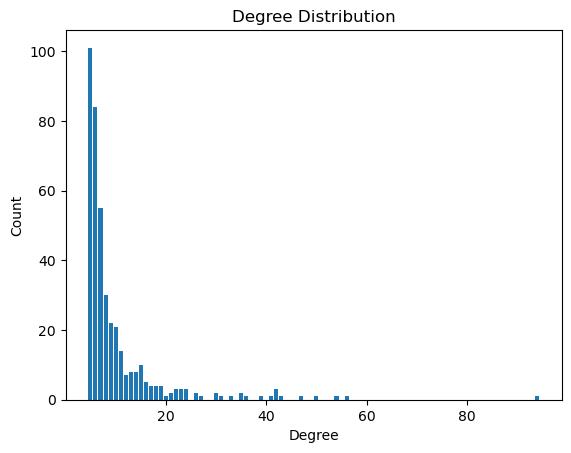

Maximum degree: 94
Average degree: 9.926829268292684
Diameter: 4
Radius: 3
Density: 0.02427097620609458


In [60]:
scale_free_410_sim.graph_metrics()

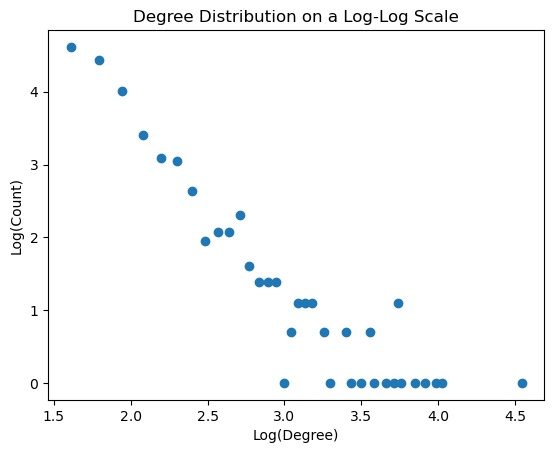

In [61]:
scale_free_410_sim.log_log_density_plot()

Test Parameters

In [62]:
population = Population(G, parameters=test_parameters)

In [63]:
scale_free_410_sim_test = Simulation('scale_free_410_test', population)

In [64]:
scale_free_410_sim_test.run()

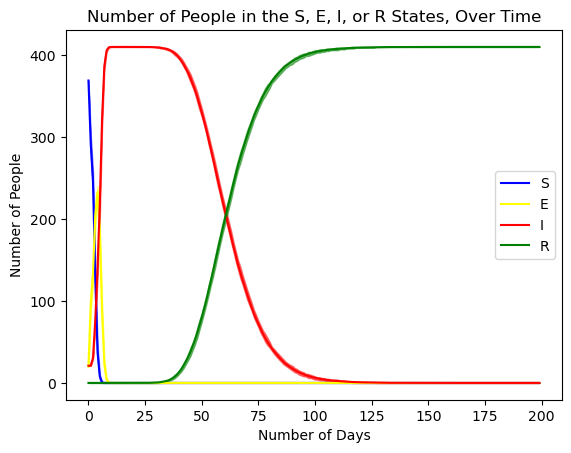

In [65]:
scale_free_410_sim_test.plot()

In [66]:
scale_free_410_sim_test.summary_statistics()

Number of peak infections (on average): 410.0
Time to peak infection (on average): 11
Time until no new infections (on average): 155
Number of uninfected individuals at the end of the simulation (on average): 0.0


### Infect Dublin

Default Parameters

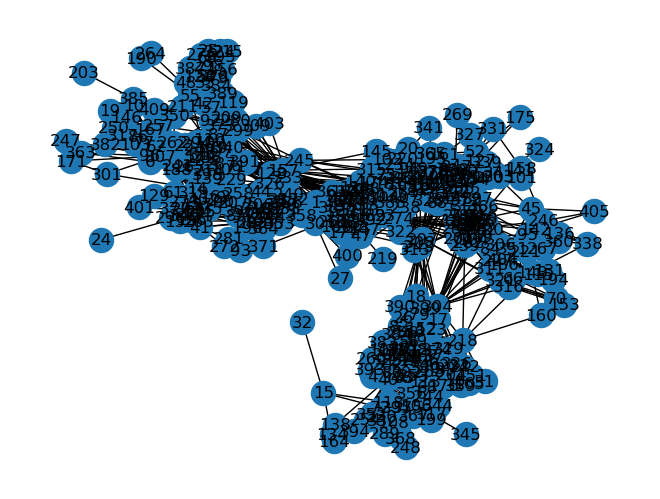

In [67]:
# Code from the lab specs (used to read in the Dublin graph)
def _read_graph_from_file(filename):
    fo = open(filename, 'r')
    line = fo.readline()  # Read file header
    line = fo.readline()  # Number of vertices and edges
    if not line:
        print('error -- illegal format for input')
        return
    v = line.split(" ")
    numVertices = int(v[0])
    G = nx.Graph()
    G.add_nodes_from(range(1,numVertices+1))
    while True:
        line = fo.readline()
        if not line:
            break
        #print("Line{}: {}".format(count,line.strip()))
        v = line.split(" ")
        v1 = int(v[0])
        v2 = int(v[1])
        G.add_edge(v1,v2)
        G.add_edge(v2,v1)
    fo.close()
    return G

G = _read_graph_from_file('./project_1_files/ia-infect-dublin.mtx')

nx.draw(G, with_labels=True)
plt.show()

In [68]:
population = Population(G)

In [69]:
infect_dublin_sim = Simulation('infect_dublin', population)

In [70]:
infect_dublin_sim.run()

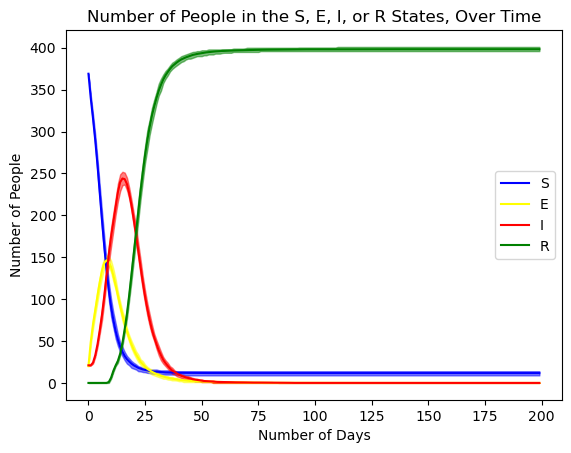

In [71]:
infect_dublin_sim.plot()

In [72]:
infect_dublin_sim.summary_statistics()

Number of peak infections (on average): 243.97
Time to peak infection (on average): 15
Time until no new infections (on average): 165
Number of uninfected individuals at the end of the simulation (on average): 11.73


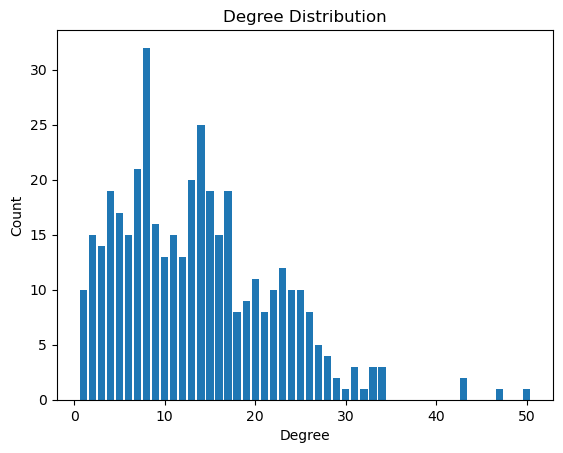

Maximum degree: 50
Average degree: 13.487804878048781
Diameter: 9
Radius: 5
Density: 0.032977518039239075


In [73]:
infect_dublin_sim.graph_metrics()

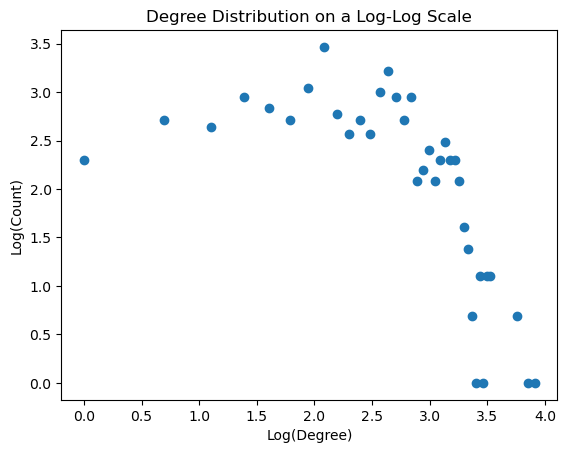

In [74]:
infect_dublin_sim.log_log_density_plot()

Test Parameters

In [75]:
population = Population(G, parameters=test_parameters)

In [76]:
infect_dublin_sim_test = Simulation('infect_dublin_test', population)

In [77]:
infect_dublin_sim_test.run()

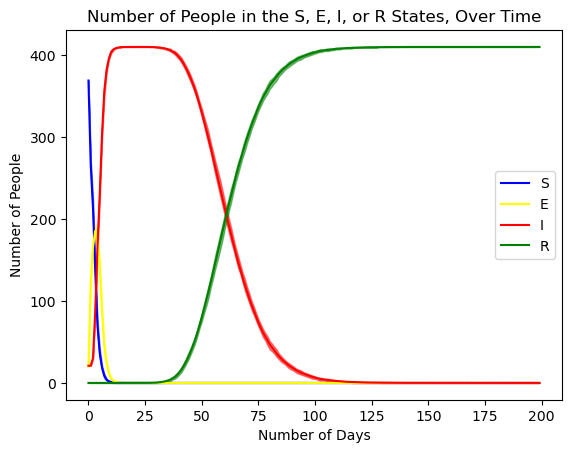

In [78]:
infect_dublin_sim_test.plot()

In [79]:
infect_dublin_sim_test.summary_statistics()

Number of peak infections (on average): 409.99
Time to peak infection (on average): 20
Time until no new infections (on average): 156
Number of uninfected individuals at the end of the simulation (on average): 0.0


# Report